# **프로젝트: 뉴스 요약봇 만들기**

#### **프로젝트 개요**  

**1. 프로젝트 목적:**  


뉴스 기사를 입력받아 핵심 내용을 자동으로 추출하고 간결한 요약문을 생성하는 
Abstractive Summarization 과 Extractive Summarization 시스템을 각각 구현하고 요약 결과를 비교 분석한다.


**2. 데이터셋: 📰 [News Summary Dataset (news_summary_more.csv)](https://github.com/sunnysai12345/News_Summary)**  
- 98,360 건의 뉴스 기사 (기자 이름, 뉴스 제목, URL, 미리보기, 전체 기사)
- 2017년 2월부터 9월까지의 기사를 포함
- 원천 소스는 Inshorts, Indian times, Guardian


**3. 평가지표:  ROUGE Score (Precision, Recall, F1-Score)**
- ROUGE-1: Unigram 겹침 (단어 수준 유사도)
- ROUGE-2: Bigram 겹침 (문법 및 어순)
- ROUGE-L: LCS (전체 구조 유사도)

<br /><br />
_*본 실험 보고서는 2026/02/03 코드 리뷰 후 수정한 버전임_

## **1. 라이브러리 불러오기**

In [1]:
# 데이터 로드
import numpy as np
import pandas as pd
import urllib.request

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from torch.nn.utils.rnn import pad_sequence

# 추상적 요약 라이브러리
from importlib.metadata import version
import nltk
from nltk.corpus import stopwords
import re

# 추출적 요약 라이브러리
from summa import summarizer
from summa import keywords
from summa import commons
from summa import pagerank_weighted

# 모델 설계
import torch
import torch.nn as nn
import torch.nn.functional as F

# 모델 훈련
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 요약 품질 평가 지표
from rouge import Rouge

# 기타 헬퍼 라이브러리
import os
from bs4 import BeautifulSoup
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(torch.__version__)
print(pd.__version__)
print(version('summa'))

3.9.2
2.7.1+cu118
2.3.0
1.2.0


## **2. 데이터 분석**

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")

('news_summary_more.csv', <http.client.HTTPMessage at 0x7cdad5864980>)

In [3]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
pd.set_option('display.max_colwidth', 500) # 열 디스플레이 옵션 설정

In [4]:
# 샘플 확인 
data.sample(10)

,headlines,text
2119,BJP flies K'taka MLAs to Gurugram resort amid poaching fears,"Karnataka BJP has flown over 100 MLAs to a resort in Gurugram amid allegations of poaching levelled by both BJP and the ruling Congress-JD(S). BJP MLA Shashikala Jolle said they had gathered there to prepare for general elections. Meanwhile, state minister DK Shivakumar alleged BJP had lured 3 Congress MLAs to a Mumbai hotel to destabilise their government."
80236,"Flight loses radio contact, escorted by German fighter jets","A South Korean aircraft, carrying 211 passengers, was escorted to Stuttgart Airport by two German military jets on Saturday evening after losing radio contact. There was a problem with the radio equipment of the Switzerland-bound flight, the police said. Meanwhile, passengers were forced to spend the night on cots at the airport's terminal because enough hotel beds were not available."
67422,No cut-off for recruiting people with disabilities: HC,"The Bombay High Court has held there shouldn't be any cut-offs for allocating posts reserved for people with disabilities. This comes after the Finance Ministry failed to appoint a visually impaired candidate to its research department on the pretext that none of the candidates could meet the cut-off. Appointments to reserved posts should be based on merit, the court added."
67177,"Sunny Leone performed for Gurmeet Ram Rahim, claims Rakhi","Rakhi Sawant has claimed that Sunny Leone had met rape convict Gurmeet Ram Rahim Singh and performed for him. While talking about the upcoming biopic on Ram Rahim, Rakhi added, ""We will take a duplicate of Sunny Leone and have an item number."" Rakhi will be seen portraying Ram Rahim's adopted daughter Honeypreet Insan in the biopic. n"
28584,Actress Brigitte Nielsen gives birth to daughter at 54,"Danish actress Brigitte Nielsen, who got married to 39-year-old Italian TV producer Mattia Dessi in 2006, has given birth to her daughter and fifth child at the age of 54. ""We are overjoyed to welcome our beautiful daughter into our lives,"" read the official statement. Neilsen, who is married for the fifth time, has four sons from her previous relationships."
82929,UK school offers 'uniform hijabs' for Muslim pupils,"A secondary school in the UK is offering hijabs or headscarves worn by Muslims as part of the uniform for pupils, becoming the first school in the country to do so. However, Muslim parents and pupils have complained that the uniform hijabs are not modest enough and could pose a suffocation risk if pulled back by other pupils."
62049,IIT Kharagpur organises campus round of Hult Prize,"IIT Kharagpur organised the campus round of Hult Prize on November 5, 2017. The Hult Prize is organised in association with the UN and is the world's largest student social entrepreneurship competition spanning across 106 countries with participation from over 50,000 universities. Team ""LOST"" was declared the winner and will now progress to one of the 15 International regionals."
76637,Jio's plea to stop Airtel's 'fastest Internet' ad rejected,"A Mumbai court has rejected Reliance Jio's plea to pull Airtel's 'Fastest Internet' speed advertisement off air. Jio stated the advertisement amounted to conspiracy, defamation, and breach of trust. The court, however, observed, ""It's nothing but a marketing policy,"" and said firms are in competition, and claim themselves to be the best by way of advertisements to expand their business."
51501,AAP moved from 'against corruption' to 'I'm corruption': BJP,"After Election Commission recommended disqualification of 20 AAP lawmakers for allegedly holding offices of profit, BJP spokesperson Sambit Patra on Friday said the AAP has moved from 'India against corruption' to 'I am corruption'. The accused MLAs were holding the post of Parliamentary Secretaries. The BJP and the Congress have demanded Delhi CM Arvind Kejriwal's resignation over the incident."
94586,Italy to trial abortion pills at family planning clinics,"Ita

In [5]:
# 전체 기사 건 수 확인 
print("뉴스 기사 건 수:", len(data))

뉴스 기사 건 수: 98401


In [6]:
# 중복값 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [7]:
# 중복값 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [8]:
# 결측값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


본문의 최소 길이 : 1
본문의 최대 길이 : 91
본문의 평균 길이 : 58.23813542090281


제목의 최소 길이 : 1
제목의 최대 길이 : 18
제목의 평균 길이 : 9.553660024400163






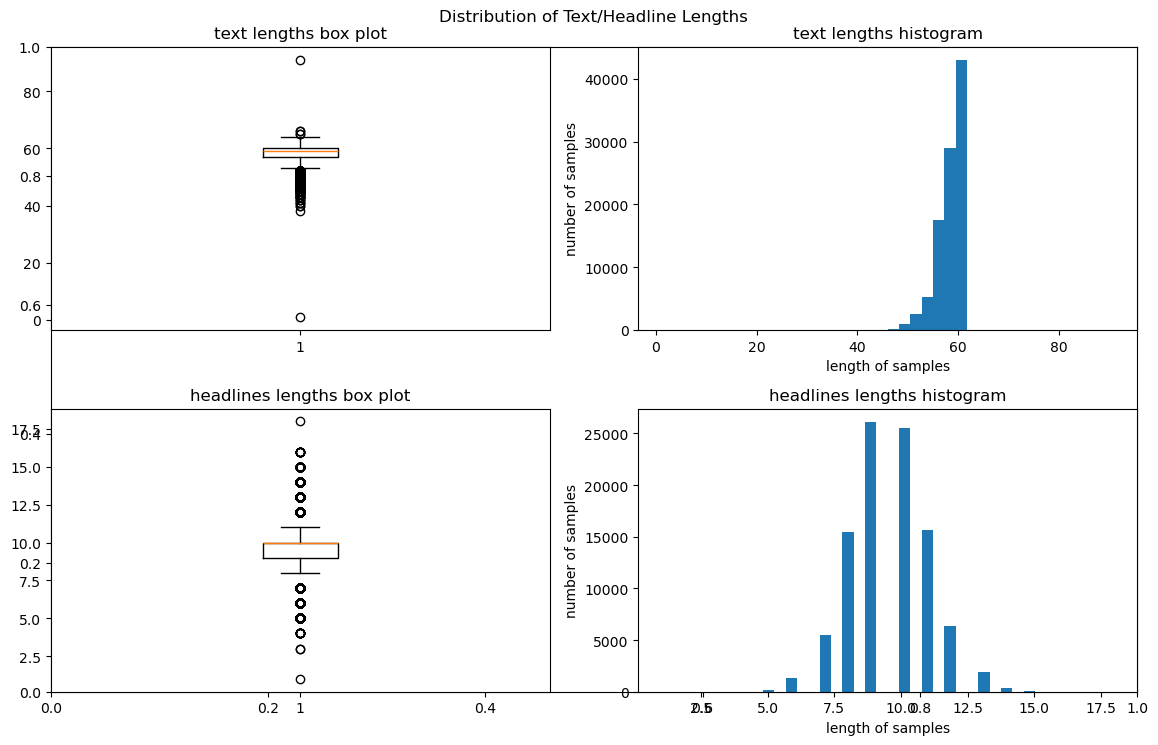

In [9]:
# 뉴스별 기사 길이 분포 확인
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('본문의 최소 길이 : {}'.format(np.min(text_len)))
print('본문의 최대 길이 : {}'.format(np.max(text_len)))
print('본문의 평균 길이 : {}'.format(np.mean(text_len)))
print("\n")
print('제목의 최소 길이 : {}'.format(np.min(summary_len)))
print('제목의 최대 길이 : {}'.format(np.max(summary_len)))
print('제목의 평균 길이 : {}'.format(np.mean(summary_len)))
print("\n")

print("=" * 80)
print("\n")

plt.figure(figsize=(12, 8))
plt.title("Distribution of Text/Headline Lengths\n")

plt.subplot(2,2,1)
plt.boxplot(text_len)
plt.title('text lengths box plot')

plt.subplot(2,2,2)
plt.title('text lengths histogram')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.subplot(2,2,3)
plt.boxplot(summary_len)
plt.title('headlines lengths box plot')

plt.subplot(2,2,4)
plt.title('headlines lengths histogram')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.tight_layout()
plt.show()

## **3. 텍스트 요약**

### **3-1. 추상적 요약 (Abstractive Summarization)**

#### 데이터 전처리

In [10]:
# 정규화 사전 정의
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 불용어 사전 정의
nltk.download('stopwords')
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...


불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
def preprocess_sentence(sentence, remove_stopwords=True, keep_numbers=True):
    """
    뉴스 기사 전처리 함수
    
    Parameters:
    sentence : str
        전처리할 문장
    remove_stopwords : bool, default=True
        불용어 제거 여부 (Text용 True, Summary용 False)
    keep_numbers : bool, default=True
        숫자 유지 여부
    
    Returns:
    str
        전처리된 문장
    """
    # 1. 텍스트 소문자화
    sentence = sentence.lower()
    
    # 2. HTML 태그 제거
    sentence = BeautifulSoup(sentence, "lxml").text
    
    # 3. URL 제거
    sentence = re.sub(r'http\S+|www\S+|https\S+', '', sentence, flags=re.MULTILINE)
    
    # 4. 이메일 주소 제거
    sentence = re.sub(r'\S+@\S+', '', sentence)
    
    # 5. 괄호로 닫힌 문자열 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    
    # 6. 쌍따옴표 제거
    sentence = re.sub('"', '', sentence)
    
    # 7. 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    
    # 8. 소유격 제거
    sentence = re.sub(r"'s\b", "", sentence)
    
    # 9. 하이픈 처리 (하이픈으로 연결된 단어를 공백으로 분리)
    sentence = re.sub(r'-', ' ', sentence)
    
    # 10. 영어와 숫자 외 문자 제거 (숫자 유지 옵션에 따라)
    if keep_numbers:
        sentence = re.sub(r"[^a-zA-Z0-9\s]", " ", sentence)  # 숫자 유지
    else:
        sentence = re.sub(r"[^a-zA-Z\s]", " ", sentence)  # 숫자 제거
    
    # 11. m이 3개 이상이면 2개로 변경
    sentence = re.sub(r'[m]{2,}', 'mm', sentence)
    
    # 12. 반복 공백 제거
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # 13. 양쪽 공백 제거
    sentence = sentence.strip()
    
    # 14. 불용어 제거 및 짧은 단어 제거
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() 
                         if word not in stopwords.words('english') 
                         and len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() 
                         if len(word) > 1)
    
    return tokens

In [13]:
# 전체 text 데이터에 대한 전처리
clean_text = []
for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence, remove_stopwords=True, keep_numbers=True))

# 전처리 후 출력
print("Text 전처리 후 결과:")
print(clean_text[:5])
print(f"\n전처리 완료: 총 {len(clean_text)}개")

# 전체 summary(Headlines) 데이터에 대한 전처리
clean_summary = []
for sentence in data['headlines']:
    clean_summary.append(preprocess_sentence(sentence, remove_stopwords=False, keep_numbers=True))

# 전처리 후 출력
print("\nSummary 전처리 후 결과:")
print(clean_summary[:5])
print(f"전처리 완료: 총 {len(clean_summary)}개")

# 데이터프레임에 추가
data['clean_text'] = clean_text
data['clean_summary'] = clean_summary

Text 전처리 후 결과:
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 y

In [14]:
# 전처리 전후 비교 (샘플 3개)
for i in range(3):
    print(f"\n[샘플 {i+1}]")
    print(f"원본 Text: {data['text'].iloc[i][:100]}...")
    print(f"전처리 Text: {data['clean_text'].iloc[i][:100]}...")
    print(f"\n원본 Summary: {data['headlines'].iloc[i]}")
    print(f"전처리 Summary: {data['clean_summary'].iloc[i]}")
    print("-" * 80)


[샘플 1]
원본 Text: Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelli...
전처리 Text: saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engin...

원본 Summary: upGrad learner switches to career in ML & Al with 90% salary hike
전처리 Summary: upgrad learner switches to career in ml al with 90 salary hike
--------------------------------------------------------------------------------

[샘플 2]
원본 Text: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swig...
전처리 Text: kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pr...

원본 Summary: Delhi techie wins free food from Swiggy for one year on CRED
전처리 Summary: delhi techie wins free food from swiggy for one year on cred
--------------------------------------------------------------------------------

[샘플 3]
원본 Text: New Zealand defeated India by 8 wickets in the f

In [15]:
# 빈 문장이나 너무 짧은 문장 확인
empty_text = data[data['clean_text'].str.strip() == '']
empty_summary = data[data['clean_summary'].str.strip() == '']

print(f"\n=== 빈 문장 확인 ===")
print(f"빈 Text: {len(empty_text)}개")
print(f"빈 Summary: {len(empty_summary)}개")

# 너무 짧은 문장 (3단어 미만) - 즉석에서 길이 계산
short_text = data[data['clean_text'].apply(lambda x: len(x.split())) < 3]
short_summary = data[data['clean_summary'].apply(lambda x: len(x.split())) < 3]

print(f"\n너무 짧은 Text (3단어 미만): {len(short_text)}개")
print(f"너무 짧은 Summary (3단어 미만): {len(short_summary)}개")


=== 빈 문장 확인 ===
빈 Text: 0개
빈 Summary: 0개

너무 짧은 Text (3단어 미만): 1개
너무 짧은 Summary (3단어 미만): 1개


In [16]:
# 텍스트 길이 자르기
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, 100 * (cnt / len(nested_list))))

In [17]:
# 본문, 제목 최대 길이 설정
text_max_len = 55
summary_max_len = 12

below_threshold_len(text_max_len, data['clean_text'])
below_threshold_len(summary_max_len, data['clean_summary'])

전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.99694997966652
전체 샘플 중 길이가 12 이하인 샘플의 비율: 97.90870272468483


In [18]:
# 샘플 길이 자르기 
data = data[data['clean_text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['clean_summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96300


In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['clean_summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['clean_summary'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,clean_text,clean_summary,decoder_input,decoder_target
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad 360 degree career support helped transition data scientist tech mahindra 90 salary hike upgrad online power learning powered lakh careers,upgrad learner switches to career in ml al with 90 salary hike,sostoken upgrad learner switches to career in ml al with 90 salary hike,upgrad learner switches to career in ml al with 90 salary hike eostoken
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.",kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending 2000 cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit,delhi techie wins free food from swiggy for one year on cred,sostoken delhi techie wins free food from swiggy for one year on cred,delhi techie wins free food from swiggy for one year on cred eostoken
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.",new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy 12 consecutive victories dating back march 2018 match witnessed india getting 92 seventh lowest total odi cricket history,new zealand end rohit sharma led india 12 match winning streak,sostoken new zealand end rohit sharma led india 12 match winning streak,new zealand end rohit sharma led india 12 match winning streak eostoken
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, customers have options to insure against Critical Illnesses, Disability and Accidental Death Benefit Rider with a life cover up to the age of 80 years.",aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 years also customers options insure critical illnesses disability accidental death benefit rider life cover age 80 years,aegon life iterm insurance plan helps customers save tax,sostoken aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan helps customers save tax eostoken
5,Rahat Fateh Ali Khan denies getting notice for smuggling currency,"Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India. ""It would have been better if the authorities would have served the notice first if any and then publicise

#### 데이터셋 분리

In [20]:
# 훈련 데이터와 테스트 데이터 분리
encoder_input = np.array(data['clean_text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[36603 45844 69290 ... 64901 41761 16285]


In [22]:
# 샘플 순서 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [23]:
# 8:2 비율로 데이터 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19260


In [24]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 77040
훈련 레이블의 개수 : 77040
테스트 데이터의 개수 : 19260
테스트 레이블의 개수 : 19260


#### 토큰화 및 단어 사전 생성

In [25]:
# 토크나이저 정의
def src_tokenizer(text):
    return text.split()  # 공백 기준 토큰화

def build_vocab(texts):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 단어 집합 생성 (빈도가 높은 순서대로)
    for word, _ in word_counter.most_common():
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

src_vocab = build_vocab(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [26]:
# 단어별 등장 횟수 파악
threshold = 7

# 전처리된 데이터 사용
text_data = data['clean_text'].tolist()
summary_data = data['clean_summary'].tolist()

# 단어 빈도수 계산
word_counter = Counter()
for text in text_data:
    word_counter.update(text.split())

total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

# 희귀 단어를 제외한 단어 사전 구축
vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩 및 미등록 단어 추가
word_index = {word: idx + 2 for idx, (word, count) in enumerate(word_counter.items()) if count >= threshold}

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 78492
등장 빈도가 6번 이하인 희귀 단어의 수: 53166
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 25326
단어 집합에서 희귀 단어의 비율: 67.73429139275339
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.079525869267749


In [27]:
src_vocab_size = 8000 # 단어 집합 크기 제한

def build_limited_vocab(texts, vocab_size):
    vocab = {"<PAD>": 0, "<UNK>": 1}  # 패딩과 UNK 토큰 추가
    word_counter = Counter()

    for text in texts:
        word_counter.update(src_tokenizer(text))  # 단어 빈도수 계산

    # 빈도가 높은 상위 vocab_size - 2개 단어만 선택 (PAD, UNK 포함)
    for word, _ in word_counter.most_common(vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

src_vocab = build_limited_vocab(encoder_input_train, src_vocab_size)

In [28]:
def text_to_sequence(texts, vocab):
    sequences = []
    for text in texts:
        sequence = [vocab.get(word, vocab["<UNK>"]) for word in src_tokenizer(text)]
        sequences.append(sequence)
    return sequences

# 텍스트 데이터 정수 시퀀스로 변환
encoder_input_train_seq = text_to_sequence(encoder_input_train, src_vocab)
encoder_input_test_seq = text_to_sequence(encoder_input_test, src_vocab)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train_seq[:3])
print(encoder_input_test_seq[:3])

[[1, 1128, 20, 231, 8, 29, 5815, 618, 44, 2035, 2564, 1, 1, 1, 2948, 870, 5815, 1751, 1394, 27, 130, 27, 416, 618, 487, 5982, 585, 299, 20, 231, 2948, 58, 2215, 5815, 1, 151, 568], [2663, 28, 1, 516, 271, 2431, 4779, 7360, 152, 218, 129, 120, 169, 2663, 1, 1179, 13, 7464, 45, 7, 271, 7464, 37, 120, 1, 633, 6215, 13, 5176, 2517, 281, 1412], [40, 74, 149, 2405, 4698, 588, 1189, 28, 5931, 1616, 234, 1129, 91, 129, 4178, 1, 1516, 7171, 399, 502, 4528, 40, 386, 314, 229, 548, 234, 1129, 71, 28, 2857, 2949, 588, 536, 656]]
[[54, 117, 47, 412, 1531, 180, 140, 6665, 91, 129, 254, 4279, 303, 393, 1660, 280, 659, 568, 119, 1531, 33, 6665, 218, 2392, 2417, 194, 38, 1259, 22, 412, 119, 141, 1811, 638, 119, 140], [740, 806, 1296, 158, 560, 436, 1171, 786, 26, 1167, 158, 560, 2102, 85, 1576, 3106, 1, 436, 1171, 158, 248, 198, 2529, 13, 5749, 2708, 2698, 2263, 1072, 4251, 598, 3720, 175, 436, 2708, 1059, 1035, 569, 2081, 411, 996], [3580, 33, 29, 1047, 1742, 1161, 3159, 2619, 2146, 4140, 55, 2606, 26

In [29]:
# target (headlines) 에도 동일한 전처리 적용
def tar_tokenizer(text):
    text = text.lower()  # 소문자로 변환
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)  # 특수문자 제거
    return text.split()  # 공백 기준 토큰화

tar_vocab = build_vocab(decoder_input_train)

In [30]:
threshold = 6

word_counter = Counter()
for text in decoder_input_train:
    word_counter.update(tar_tokenizer(text))  # 각 문장의 단어 빈도 계산

# 전체 단어 개수 및 등장 빈도 계산
total_cnt = len(word_counter)  # 전체 단어 개수
total_freq = sum(word_counter.values())  # 전체 단어 등장 횟수
rare_cnt = sum(1 for count in word_counter.values() if count < threshold)  # 희귀 단어 개수
rare_freq = sum(count for count in word_counter.values() if count < threshold)  # 희귀 단어 등장 횟수

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 31717
등장 빈도가 5번 이하인 희귀 단어의 수: 21041
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10676
단어 집합에서 희귀 단어의 비율: 66.33981776334458
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.969790089367892


In [31]:
tar_vocab_size = 2000 # 단어 집합 크기 제한 
tar_vocab = build_limited_vocab(decoder_input_train + decoder_target_train, tar_vocab_size)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train_seq = text_to_sequence(decoder_input_train, tar_vocab)
decoder_target_train_seq = text_to_sequence(decoder_target_train, tar_vocab)
decoder_input_test_seq = text_to_sequence(decoder_input_test, tar_vocab)
decoder_target_test_seq = text_to_sequence(decoder_target_test, tar_vocab)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train_seq[:5])
print('target')
print('decoder ',decoder_target_train_seq[:5])

input
input  [[2, 696, 1, 1427, 341, 1, 9, 1, 1], [2, 272, 1209, 166, 660, 50, 391, 1, 1, 116, 5, 1600], [2, 22, 1, 141, 1184, 707, 1428, 166, 144, 1], [2, 19, 66, 1, 1, 10, 1, 1, 1, 311, 1], [2, 1, 754, 4, 1, 1, 665, 1850, 5]]
target
decoder  [[696, 1, 1427, 341, 1, 9, 1, 1, 3], [272, 1209, 166, 660, 50, 391, 1, 1, 116, 5, 1600, 3], [22, 1, 141, 1184, 707, 1428, 166, 144, 1, 3], [19, 66, 1, 1, 10, 1, 1, 1, 311, 1, 3], [1, 754, 4, 1, 1, 665, 1850, 5, 3]]


In [32]:
# 시작 또는 종료 토큰만 남은 샘플 제거 (길이 == 1)
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77040
훈련 레이블의 개수 : 77040
테스트 데이터의 개수 : 19260
테스트 레이블의 개수 : 19260


#### 패딩 적용

In [33]:
# 패딩 추가
def convert_to_tensor(sequences): # 텐서 변환 함수 (리스트 → PyTorch 텐서)
    return [torch.tensor(seq, dtype=torch.long) for seq in sequences]

# 패딩 적용 함수
def pad_sequences_pytorch(sequences, maxlen, padding_value=0):
    sequences = convert_to_tensor(sequences)  # 리스트를 텐서로 변환
    padded_seqs = pad_sequence(sequences, batch_first=True, 
                               padding_value=padding_value, 
                               padding_side='left') # pre-padding
    return padded_seqs[:, :maxlen]  # maxlen 길이로 자르기 (최대 길이 초과 방지)

# 패딩 적용
encoder_input_train = pad_sequences_pytorch(encoder_input_train_seq, maxlen=text_max_len)
encoder_input_test = pad_sequences_pytorch(encoder_input_test_seq, maxlen=text_max_len)
decoder_input_train = pad_sequences_pytorch(decoder_input_train_seq, maxlen=summary_max_len)
decoder_target_train = pad_sequences_pytorch(decoder_target_train_seq, maxlen=summary_max_len)
decoder_input_test = pad_sequences_pytorch(decoder_input_test_seq, maxlen=summary_max_len)
decoder_target_test = pad_sequences_pytorch(decoder_target_test_seq, maxlen=summary_max_len)

In [34]:
# 패딩 적용 확인
print(encoder_input_train[:3])

tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    1, 1128,   20,  231,    8,   29, 5815,
          618,   44, 2035, 2564,    1,    1,    1, 2948,  870, 5815, 1751, 1394,
           27,  130,   27,  416,  618,  487, 5982,  585,  299,   20,  231, 2948,
           58, 2215, 5815,    1,  151,  568],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2663,   28,
            1,  516,  271, 2431, 4779, 7360,  152,  218,  129,  120,  169, 2663,
            1, 1179,   13, 7464,   45,    7,  271, 7464,   37,  120,    1,  633,
         6215,   13, 5176, 2517,  281, 1412],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,   40,   74,  149, 2405, 4698,
          588, 1189,   28, 5931, 1616,  234, 1129,   91,  129, 4178,    1, 1516,
         7171,  3

#### 모델 설계

In [35]:
# 인코더 설계
class Encoder(nn.Module):
    """
    양방향 LSTM을 사용하는 인코더
    - 양방향 LSTM: 문장을 앞뒤로 모두 읽어 문맥을 더 잘 이해
    - Dropout: 과적합 방지
    """
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 임베딩 층: 단어 인덱스를 벡터로 변환
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # 양방향 LSTM 사용 (bidirectional=True)
        # 양방향이므로 실제 hidden_size는 절반으로 설정
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_size // 2,  # 양방향이므로 절반 크기 사용
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,  # 층이 1개면 dropout 불필요
            batch_first=True,
            bidirectional=True  # 양방향 LSTM
        )
        
        # Dropout 층 추가
        self.dropout = nn.Dropout(dropout)
    
    def _combine_bidirectional(self, state):
        """양방향 LSTM의 forward와 backward 상태를 결합"""
        # state shape: (num_layers*2, batch_size, hidden_size//2)
        batch_size = state.size(1)
        # forward와 backward를 분리
        forward = state[0:state.size(0):2]  # 짝수 인덱스
        backward = state[1:state.size(0):2]  # 홀수 인덱스
        # concat
        combined = torch.cat([forward, backward], dim=2)  # (num_layers, batch_size, hidden_size)
        return combined
        
    def forward(self, x):
        """
        Args:
            x: 인코더 입력 (batch_size, seq_len)
        Returns:
            outputs: 모든 타임스텝의 hidden state (batch_size, seq_len, hidden_size)
            hidden: 마지막 hidden state (num_layers, batch_size, hidden_size)
            cell: 마지막 cell state (num_layers, batch_size, hidden_size)
        """
        # 임베딩 + Dropout
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq_len, embedding_dim)
        
        # LSTM 실행
        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs: (batch_size, seq_len, hidden_size)
        # hidden/cell: (num_layers*2, batch_size, hidden_size//2) - 양방향이므로 *2
        
        # 양방향 hidden state를 결합 (forward + backward)
        # hidden shape: (num_layers*2, batch_size, hidden_size//2)
        # -> (num_layers, batch_size, hidden_size)
        hidden = self._combine_bidirectional(hidden)
        cell = self._combine_bidirectional(cell)
        
        return outputs, hidden, cell

In [36]:
# Luong 스타일 어텐션 메커니즘
class LuongAttention(nn.Module):
    """
    Luong et al. 2015의 dot-product 어텐션
    - 디코더의 현재 hidden state와 인코더의 모든 hidden states 간의 유사도 계산
    - Softmax로 정규화하여 가중치 생성
    - 가중합으로 context vector 생성
    """
    def __init__(self, hidden_size):
        super(LuongAttention, self).__init__()
        self.hidden_size = hidden_size
        
    def forward(self, decoder_hidden, encoder_outputs, mask=None):
        """
        Args:
            decoder_hidden: 디코더의 현재 hidden state (batch_size, 1, hidden_size)
            encoder_outputs: 인코더의 모든 outputs (batch_size, src_len, hidden_size)
            mask: 패딩 마스크 (batch_size, src_len) - 패딩 위치는 True
        Returns:
            context: 어텐션 적용된 context vector (batch_size, 1, hidden_size)
            attn_weights: 어텐션 가중치 (batch_size, 1, src_len)
        """
        # Dot-product 어텐션 스코어 계산
        # (batch_size, 1, hidden_size) x (batch_size, hidden_size, src_len)
        # -> (batch_size, 1, src_len)
        attn_scores = torch.bmm(decoder_hidden, encoder_outputs.transpose(1, 2))
        
        # 패딩 마스킹 (선택사항이지만 성능 향상에 도움)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask.unsqueeze(1), float('-inf'))
        
        # Softmax로 정규화하여 어텐션 가중치 생성
        attn_weights = F.softmax(attn_scores, dim=-1)  # (batch_size, 1, src_len)
        
        # Context vector 계산 (가중합)
        # (batch_size, 1, src_len) x (batch_size, src_len, hidden_size)
        # -> (batch_size, 1, hidden_size)
        context = torch.bmm(attn_weights, encoder_outputs)
        
        return context, attn_weights

In [37]:
# 디코더 설계
class Decoder(nn.Module):
    """
    어텐션이 통합된 LSTM 디코더
    - 각 타임스텝마다 어텐션을 계산하여 context 반영
    """
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=3, dropout=0.4):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 임베딩 층
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM 층
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hidden, cell):
        """
        Args:
            x: 디코더 입력 (batch_size, seq_len)
            hidden: 초기 hidden state (num_layers, batch_size, hidden_size)
            cell: 초기 cell state (num_layers, batch_size, hidden_size)
        Returns:
            outputs: LSTM outputs (batch_size, seq_len, hidden_size)
            hidden: 최종 hidden state
            cell: 최종 cell state
        """
        # 임베딩 + Dropout
        embedded = self.dropout(self.embedding(x))  # (batch_size, seq_len, embedding_dim)
        
        # LSTM 실행 (초기 상태를 인코더에서 받음)
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # outputs: (batch_size, seq_len, hidden_size)
        
        return outputs, hidden, cell

In [38]:
# Seq2Seq with Attention (통합 모델)
class Seq2SeqWithAttention(nn.Module):
    """
    어텐션 메커니즘이 통합된 Seq2Seq 모델
    1. 양방향 인코더
    2. Residual connection (잔차 연결)
    3. Layer Normalization
    4. Padding masking
    5. Dropout
    """
    def __init__(self, encoder, decoder, vocab_size, hidden_size, dropout=0.3):
        super(Seq2SeqWithAttention, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.attention = LuongAttention(hidden_size)
        
        # 어텐션 결합을 위한 선형 변환
        # decoder output + context를 결합 (hidden_size * 2 -> hidden_size)
        self.concat_layer = nn.Linear(hidden_size * 2, hidden_size)
        
        # Layer Normalization (학습 안정화)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # 최종 출력층
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, encoder_input, decoder_input):
        """
        Args:
            encoder_input: 인코더 입력 (batch_size, src_len)
            decoder_input: 디코더 입력 (batch_size, tar_len)
        Returns:
            output: 최종 출력 (batch_size, tar_len, vocab_size)
        """
        # 1. 인코더 실행
        encoder_outputs, hidden, cell = self.encoder(encoder_input)
        # encoder_outputs: (batch_size, src_len, hidden_size)
        
        # 2. 디코더 실행 (인코더의 마지막 상태를 초기 상태로 사용)
        decoder_outputs, _, _ = self.decoder(decoder_input, hidden, cell)
        # decoder_outputs: (batch_size, tar_len, hidden_size)
        
        # 3. 각 타임스텝마다 어텐션 적용
        batch_size, tar_len, hidden_size = decoder_outputs.size()
        
        # 어텐션을 위한 마스크 생성 (인코더 입력의 패딩 위치)
        encoder_mask = (encoder_input == 0)  # (batch_size, src_len)
        
        # 각 타임스텝의 context vector를 저장할 텐서
        contexts = []
        
        for t in range(tar_len):
            # 현재 타임스텝의 디코더 hidden state
            decoder_hidden_t = decoder_outputs[:, t:t+1, :]  # (batch_size, 1, hidden_size)
            
            # 어텐션 계산
            context_t, _ = self.attention(decoder_hidden_t, encoder_outputs, encoder_mask)
            # context_t: (batch_size, 1, hidden_size)
            
            contexts.append(context_t)
        
        # 모든 타임스텝의 context를 결합
        context_vectors = torch.cat(contexts, dim=1)  # (batch_size, tar_len, hidden_size)
        
        # 4. 디코더 출력과 context vector를 결합
        # Concatenate: [decoder_output; context]
        combined = torch.cat([decoder_outputs, context_vectors], dim=-1)
        # combined: (batch_size, tar_len, hidden_size * 2)
        
        # 5. 선형 변환 + tanh 활성화
        concat_output = torch.tanh(self.concat_layer(combined))
        # concat_output: (batch_size, tar_len, hidden_size)
        
        # 6. Residual connection (잔차 연결) - 디코더 출력을 더해줌
        # 이를 통해 gradient flow 개선
        concat_output = concat_output + decoder_outputs
        
        # 7. Layer Normalization
        concat_output = self.layer_norm(concat_output)
        
        # 8. Dropout
        concat_output = self.dropout(concat_output)
        
        # 9. 최종 출력층 (vocab_size 차원으로 투영)
        output = self.output_layer(concat_output)
        # output: (batch_size, tar_len, vocab_size)
        
        return output

#### 모델 훈련

In [39]:
# 모델 생성 및 초기화

# 하이퍼파라미터
embedding_dim = 128
hidden_size = 256
num_layers = 3
dropout = 0.4

# 인코더, 디코더 생성
encoder = Encoder(src_vocab_size, embedding_dim, hidden_size, num_layers, dropout)
decoder = Decoder(tar_vocab_size, embedding_dim, hidden_size, num_layers, dropout)

# Seq2Seq 모델 생성
model = Seq2SeqWithAttention(encoder, decoder, tar_vocab_size, hidden_size, dropout=0.3)

In [40]:
# GPU 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


Seq2SeqWithAttention(
  (encoder): Encoder(
    (embedding): Embedding(8000, 128, padding_idx=0)
    (lstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(2000, 128, padding_idx=0)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (attention): LuongAttention()
  (concat_layer): Linear(in_features=512, out_features=256, bias=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output_layer): Linear(in_features=256, out_features=2000, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [41]:
# 하이퍼파라미터 정의
batch_size = 256
epochs = 50
learning_rate = 0.001
patience = 4

In [42]:
# 손실 함수 & 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩 토큰 무시
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# PyTorch DataLoader 설정
train_dataset = TensorDataset(encoder_input_train, decoder_input_train, decoder_target_train)
test_dataset = TensorDataset(encoder_input_test, decoder_input_test, decoder_target_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
# 훈련 함수 정의
train_losses = []
val_losses = []

# 학습 함수
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs, patience):
    model.train()
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0

        for encoder_input, decoder_input, target in train_loader:
            optimizer.zero_grad()

            # 정수형 변환
            encoder_input = encoder_input.to(device).long()
            decoder_input = decoder_input.to(device).long()
            target = target.to(device).long()

            # 모델 실행
            output = model(encoder_input, decoder_input)
            output = output.view(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Validation loss 계산
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device).long()
                decoder_input = decoder_input.to(device).long()
                target = target.to(device).long()

                output = model(encoder_input, decoder_input)
                output = output.view(-1, output.shape[-1])
                target = target.view(-1)
                loss = criterion(output, target)

                val_loss += loss.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        model.train()

In [44]:
# 모델 훈련
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs, patience=patience)

Epoch 1/50 | Train Loss: 5.2709 | Val Loss: 4.8022
Epoch 2/50 | Train Loss: 4.6272 | Val Loss: 4.2458
Epoch 3/50 | Train Loss: 4.2615 | Val Loss: 3.9425
Epoch 4/50 | Train Loss: 4.0262 | Val Loss: 3.7334
Epoch 5/50 | Train Loss: 3.8566 | Val Loss: 3.5784
Epoch 6/50 | Train Loss: 3.7232 | Val Loss: 3.4675
Epoch 7/50 | Train Loss: 3.6155 | Val Loss: 3.3728
Epoch 8/50 | Train Loss: 3.5250 | Val Loss: 3.2960
Epoch 9/50 | Train Loss: 3.4444 | Val Loss: 3.2103
Epoch 10/50 | Train Loss: 3.3719 | Val Loss: 3.1524
Epoch 11/50 | Train Loss: 3.3090 | Val Loss: 3.1019
Epoch 12/50 | Train Loss: 3.2512 | Val Loss: 3.0544
Epoch 13/50 | Train Loss: 3.1980 | Val Loss: 3.0170
Epoch 14/50 | Train Loss: 3.1498 | Val Loss: 2.9774
Epoch 15/50 | Train Loss: 3.1054 | Val Loss: 2.9517
Epoch 16/50 | Train Loss: 3.0618 | Val Loss: 2.9127
Epoch 17/50 | Train Loss: 3.0206 | Val Loss: 2.8846
Epoch 18/50 | Train Loss: 2.9858 | Val Loss: 2.8537
Epoch 19/50 | Train Loss: 2.9520 | Val Loss: 2.8399
Epoch 20/50 | Train L

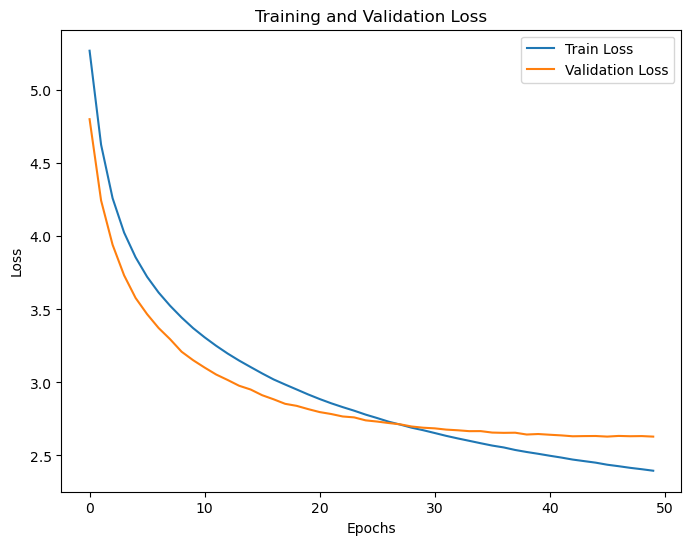

In [45]:
# loss 변화 추이 시각화
plt.figure(figsize=(8,6))
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

`patience` 인자의 값을 4로 설정해서 그런가 early stopping 없이 50 에폭 전부 학습을 진행했다. 25번째 에폭 전후로 train, val loss가 점점 줄어들다가 val loss가 증가하는 과적합 양상을 보였다. 

#### 모델 테스트

In [46]:
# 필요한 사전 준비
src_index_to_word = {idx: word for word, idx in src_vocab.items()}  # 원문: 정수 -> 단어
tar_word_to_index = tar_vocab  # 요약: 단어 -> 정수
tar_index_to_word = {idx: word for word, idx in tar_vocab.items()}  # 요약: 정수 -> 단어

In [47]:
# 인퍼런스용 인코더 함수 정의
def encode_input(encoder, input_seq):
    """
    인코더를 실행하여 출력과 초기 상태를 반환
    
    Args:
        encoder: 학습된 인코더 모델
        input_seq: 입력 시퀀스 (batch_size, seq_len)
    
    Returns:
        encoder_outputs: 모든 타임스텝의 hidden states
        hidden: 마지막 hidden state
        cell: 마지막 cell state
    """
    with torch.no_grad():
        encoder_outputs, hidden, cell = encoder(input_seq)
    return encoder_outputs, hidden, cell

In [48]:
# 어텐션 메커니즘 (인퍼런스용)
class Attention_dot(nn.Module):
    """
    Dot-product 어텐션 (Luong 스타일)
    디코더의 현재 상태와 인코더의 모든 출력 간의 유사도 계산
    """
    def __init__(self, hidden_size):
        super(Attention_dot, self).__init__()
        self.hidden_size = hidden_size
    
    def forward(self, decoder_output, encoder_outputs, mask=None):
        """
        Args:
            decoder_output: 디코더의 현재 출력 (batch_size, 1, hidden_size)
            encoder_outputs: 인코더의 모든 출력 (batch_size, src_len, hidden_size)
            mask: 패딩 마스크 (선택사항)
        
        Returns:
            context: 어텐션이 적용된 context vector (batch_size, 1, hidden_size)
        """
        # Dot-product 어텐션 스코어 계산
        # (batch_size, 1, hidden_size) x (batch_size, hidden_size, src_len)
        attn_scores = torch.bmm(decoder_output, encoder_outputs.transpose(1, 2))
        # attn_scores: (batch_size, 1, src_len)
        
        # 패딩 마스킹 (선택사항)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask.unsqueeze(1), float('-inf'))
        
        # Softmax로 어텐션 가중치 정규화
        attn_weights = F.softmax(attn_scores, dim=-1)
        
        # Context vector 계산 (가중합)
        # (batch_size, 1, src_len) x (batch_size, src_len, hidden_size)
        context = torch.bmm(attn_weights, encoder_outputs)
        # context: (batch_size, 1, hidden_size)
        
        return context

In [49]:
# 인퍼런스용 디코더 모델 (어텐션 포함)
class DecoderWithAttention(nn.Module):
    """
    인퍼런스 단계에서 사용되는 디코더 모델
    - 한 타임스텝씩 단어를 생성
    - 어텐션 메커니즘 적용
    - 이전 상태를 입력으로 받아 다음 상태 출력
    """
    def __init__(self, decoder, attention, hidden_size, vocab_size, dropout=0.3):
        super(DecoderWithAttention, self).__init__()
        self.decoder = decoder  # 학습된 디코더 (LSTM + Embedding)
        self.attention = attention  # 어텐션 레이어
        
        # 어텐션 결합 레이어: [decoder_output; context] -> hidden_size
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        
        # Layer Normalization (학습 안정화)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # 최종 출력층: hidden_size -> vocab_size
        self.output_layer = nn.Linear(hidden_size, vocab_size)
        
        # Softmax (확률 분포 생성)
        self.softmax = nn.Softmax(dim=-1)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, decoder_input, encoder_outputs, hidden, cell, encoder_mask=None):
        """
        한 타임스텝에 대한 디코더 실행
        
        Args:
            decoder_input: 현재 타임스텝의 입력 (batch_size, 1) - 이전에 생성된 단어
            encoder_outputs: 인코더의 모든 출력 (batch_size, src_len, hidden_size)
            hidden: 이전 타임스텝의 hidden state (num_layers, batch_size, hidden_size)
            cell: 이전 타임스텝의 cell state (num_layers, batch_size, hidden_size)
            encoder_mask: 인코더 입력의 패딩 마스크 (선택사항)
        
        Returns:
            output_probs: 다음 단어의 확률 분포 (batch_size, 1, vocab_size)
            hidden: 현재 타임스텝의 hidden state
            cell: 현재 타임스텝의 cell state
        """
        # 1. 디코더 LSTM 실행
        decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
        # decoder_output: (batch_size, 1, hidden_size)
        
        # 2. 어텐션 적용
        context = self.attention(decoder_output, encoder_outputs, encoder_mask)
        # context: (batch_size, 1, hidden_size)
        
        # 3. 디코더 출력과 context vector 결합
        concat_output = torch.cat([decoder_output, context], dim=-1)
        # concat_output: (batch_size, 1, hidden_size * 2)
        
        # 4. 선형 변환 + tanh 활성화
        combined = torch.tanh(self.concat(concat_output))
        # combined: (batch_size, 1, hidden_size)
        
        # 5. Residual connection (잔차 연결)
        combined = combined + decoder_output
        
        # 6. Layer Normalization
        combined = self.layer_norm(combined)
        
        # 7. Dropout
        combined = self.dropout(combined)
        
        # 8. 최종 출력층 + Softmax
        output_logits = self.output_layer(combined)
        # output_logits: (batch_size, 1, vocab_size)
        
        output_probs = self.softmax(output_logits)
        # output_probs: (batch_size, 1, vocab_size)
        
        return output_probs, hidden, cell

In [50]:
# 인퍼런스용 디코더 모델 생성

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 학습된 모델의 인코더, 디코더 추출
encoder = model.encoder
decoder = model.decoder

# 인코더와 디코더를 evaluation 모드로 설정
encoder.eval()
decoder.eval()

# 어텐션 레이어 생성
attention_layer = Attention_dot(hidden_size)

# 인퍼런스용 디코더 모델 생성
decoder_model = DecoderWithAttention(
    decoder, 
    attention_layer, 
    hidden_size, 
    tar_vocab_size,
    dropout=0.0  # 인퍼런스 시에는 dropout 사용 안 함
)

# 디바이스로 이동
encoder.to(device)
decoder_model.to(device)

# Evaluation 모드
decoder_model.eval()

DecoderWithAttention(
  (decoder): Decoder(
    (embedding): Embedding(2000, 128, padding_idx=0)
    (lstm): LSTM(128, 256, num_layers=3, batch_first=True, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (attention): Attention_dot()
  (concat): Linear(in_features=512, out_features=256, bias=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output_layer): Linear(in_features=256, out_features=2000, bias=True)
  (softmax): Softmax(dim=-1)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [51]:
# 시퀀스 디코딩 함수 (문장 생성)
def decode_sequence(input_seq, encoder, decoder_model, tar_word_to_index, tar_index_to_word, 
                    text_max_len, summary_max_len, device):
    """
    입력 시퀀스를 받아 요약문을 생성하는 함수
    
    Args:
        input_seq: 원문의 정수 시퀀스 (list or array)
        encoder: 학습된 인코더 모델
        decoder_model: 인퍼런스용 디코더 모델
        tar_word_to_index: 요약 단어 -> 정수 사전
        tar_index_to_word: 요약 정수 -> 단어 사전
        text_max_len: 원문 최대 길이
        summary_max_len: 요약문 최대 길이
        device: 디바이스 (cuda/cpu)
    
    Returns:
        decoded_sentence: 생성된 요약문 (문자열)
    """
    # 1. 입력을 PyTorch Tensor로 변환하고 device로 이동
    if not isinstance(input_seq, torch.Tensor):
        input_seq = torch.tensor(input_seq, dtype=torch.long).to(device)  # device로 이동!
    else:
        input_seq = input_seq.to(device)  # 이미 Tensor인 경우에도 device로 이동
    
    # 배치 차원이 없으면 추가
    if input_seq.dim() == 1:
        input_seq = input_seq.unsqueeze(0)  # (seq_len) -> (1, seq_len)
    
    # 2. 인코더 실행 (초기 상태 얻기)
    with torch.no_grad():
        encoder_outputs, hidden, cell = encoder(input_seq)
    # encoder_outputs: (1, src_len, hidden_size)
    # hidden/cell: (num_layers, 1, hidden_size)
    
    # 3. 패딩 마스크 생성 (선택사항)
    encoder_mask = (input_seq == 0)  # (1, src_len)
    
    # 4. 디코더 초기 입력: <SOS> 토큰
    decoder_input = torch.zeros((1, 1), dtype=torch.long, device=device)
    decoder_input[0, 0] = tar_word_to_index['sostoken']
    
    # 5. 생성된 문장을 저장할 변수
    decoded_sentence = ''
    stop_condition = False
    
    # 6. 단어를 하나씩 생성 (최대 길이까지)
    step = 0
    while not stop_condition:
        # 디코더 실행 (한 타임스텝)
        with torch.no_grad():
            output_probs, hidden, cell = decoder_model(
                decoder_input, 
                encoder_outputs, 
                hidden, 
                cell,
                encoder_mask
            )
        # output_probs: (1, 1, vocab_size)
        
        # 가장 높은 확률을 가진 단어 선택 (greedy decoding)
        sampled_token_index = torch.argmax(output_probs[0, -1, :]).item()
        sampled_token = tar_index_to_word[sampled_token_index]
        
        # <EOS> 토큰이 아니면 문장에 추가
        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token
        
        # 7. 종료 조건 확인
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True
        
        # 8. 다음 타임스텝을 위한 입력 업데이트
        decoder_input = torch.zeros((1, 1), dtype=torch.long, device=device)
        decoder_input[0, 0] = sampled_token_index
        
        step += 1
        
        # 안전장치: 무한 루프 방지
        if step > summary_max_len * 2:
            break
    
    return decoded_sentence.strip()

In [52]:
# 헬퍼 함수들
def seq2text(input_seq):
    """
    원문의 정수 시퀀스를 텍스트로 변환
    
    Args:
        input_seq: 정수 시퀀스 (PyTorch Tensor)
    
    Returns:
        텍스트 문자열
    """
    temp = ''
    for i in input_seq:
        key = int(i.item())  # Tensor -> int 변환
        if key != 0:  # 패딩 제외
            temp = temp + src_index_to_word.get(key, "<UNK>") + ' '
    return temp.strip()


def seq2summary(input_seq):
    """
    요약문의 정수 시퀀스를 텍스트로 변환
    
    Args:
        input_seq: 정수 시퀀스 (PyTorch Tensor)
    
    Returns:
        텍스트 문자열
    """
    temp = ''
    for i in input_seq:
        key = int(i.item())  # Tensor -> int 변환
        # 패딩, <SOS>, <EOS> 토큰 제외
        if key != 0 and key != tar_word_to_index['sostoken'] and key != tar_word_to_index['eostoken']:
            temp = temp + tar_index_to_word.get(key, "<UNK>") + ' '
    return temp.strip()

In [53]:
# 테스트
test_idx = 5
input_seq = encoder_input_test[test_idx]
original_text = seq2text(input_seq)
actual_summary = seq2summary(decoder_target_test[test_idx])

# 요약문 생성
predicted_summary = decode_sequence(
    input_seq, 
    encoder, 
    decoder_model, 
    tar_word_to_index, 
    tar_index_to_word,
    text_max_len=encoder_input_test.shape[1],
    summary_max_len=decoder_target_test.shape[1],
    device=device
)

print(f"원문: {original_text}")
print(f"실제 요약: {actual_summary}")
print(f"생성 요약: {predicted_summary}")

원문: pm narendra modi sunday said world <UNK> ease business central government talks ease living congress government karnataka talks ease murder addressing rally poll bound karnataka pm modi also said people oppose ruling congress state end losing lives
실제 요약: taka cong govt talks <UNK> of doing murder pm modi
생성 요약: visit their manager where 12 cost cost cost company black thai


생성된 요약문을 보니 같은 단어가 반복적으로 나열된 것을 알 수 있다. 이것으로 미루어 볼 때 모델이 문맥을 충분히 파악하지 못하고 지역적인 통계(특정 단어 뒤에 특정 단어가 올 확률)에만 의존하고 있을 가능성이 크다. 찾아보니 이는 이는 Greedy 디코딩(가장 높은 확률의 단어만 선택)를 사용할 때 흔히 발생하는 문제라고 한다.  

또한 원문에 Unknown 토큰이 섞여 있는 걸 보면 전처리 과정에서 너무 많은 단어가 제거되어 어텐션 메커니즘이 원문의 핵심 정보를 제대로 참조하지 못했을 경우도 존재한다.

#### 디코딩 전략 변경

Greedy 디코딩에서 발생하는 토큰 반복 문제를 완화하기 위해 반복 페널티를 적용한 Greedy + Repetition penalty로 개선한다. 이 방식은 이미 생성된 토큰의 확률을 페널티 값으로 나누어 다양한 어휘 선택을 유도하고 요약문의 품질을 개선한다. (참고 - [Huggingface Transformers](https://huggingface.co/docs/transformers/main_classes/text_generation#transformers.GenerationConfig.repetition_penalty))

In [54]:
def decode_sequence_with_repetition_penalty(input_seq, encoder, decoder_model, tar_word_to_index, 
                                            tar_index_to_word, text_max_len, summary_max_len, 
                                            device, repetition_penalty=2.0):
    """
    반복 페널티를 적용한 시퀀스 디코딩
    """
    if not isinstance(input_seq, torch.Tensor):
        input_seq = torch.tensor(input_seq, dtype=torch.long).to(device)
    else:
        input_seq = input_seq.to(device)
    
    if input_seq.dim() == 1:
        input_seq = input_seq.unsqueeze(0)
    
    with torch.no_grad():
        encoder_outputs, hidden, cell = encoder(input_seq)
    
    encoder_mask = (input_seq == 0)
    decoder_input = torch.zeros((1, 1), dtype=torch.long, device=device)
    decoder_input[0, 0] = tar_word_to_index['sostoken']
    
    decoded_sentence = ''
    generated_tokens = []  # 이미 생성된 토큰 추적
    stop_condition = False
    step = 0
    
    while not stop_condition:
        with torch.no_grad():
            output_probs, hidden, cell = decoder_model(
                decoder_input, 
                encoder_outputs, 
                hidden, 
                cell,
                encoder_mask
            )
        
        # 반복 페널티 적용
        output_probs_modified = output_probs.clone()
        for token_idx in generated_tokens:
            # 이미 생성된 토큰의 확률을 감소
            output_probs_modified[0, 0, token_idx] /= repetition_penalty
        
        # 확률을 다시 정규화
        output_probs_modified = F.softmax(output_probs_modified[0, 0, :], dim=-1)
        
        # 가장 높은 확률의 단어 선택
        sampled_token_index = torch.argmax(output_probs_modified).item()
        sampled_token = tar_index_to_word[sampled_token_index]
        
        # 생성된 토큰 추적
        generated_tokens.append(sampled_token_index)
        
        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token
        
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1):
            stop_condition = True
        
        decoder_input = torch.zeros((1, 1), dtype=torch.long, device=device)
        decoder_input[0, 0] = sampled_token_index
        
        step += 1
        if step > summary_max_len * 2:
            break
    
    return decoded_sentence.strip()

In [55]:
predicted_summary = decode_sequence_with_repetition_penalty(
    input_seq, 
    encoder, 
    decoder_model, 
    tar_word_to_index, 
    tar_index_to_word,
    text_max_len=encoder_input_test.shape[1],
    summary_max_len=decoder_target_test.shape[1],
    device=device,
    repetition_penalty=2.5  # 높을수록 반복 억제 강함
)

print(f"생성 요약 (반복 페널티): {predicted_summary}")

생성 요약 (반복 페널티): visit their manager where 12 cost place iraq winter bodies pant


### **3-2. 추출적 요약 (Extractive Summarization)**

#### `ratio` 결정

In [56]:
def analyze_text_summarization(data, n=10, ratios=[0.2, 0.4, 0.6], random_state=42):
    """
    텍스트 요약 분석 함수
    
    Parameters:
    data : pd.DataFrame
        'headlines'와 'text' 컬럼을 포함한 데이터프레임
    n : int, default=10
        추출할 샘플 개수
    ratios : list, default=[0.2, 0.4, 0.6]
        요약 비율 리스트
    random_state : int, default=42
        재현성을 위한 랜덤 시드
    """
    # 무작위로 n개의 샘플 추출
    samples = data.sample(n=n, random_state=random_state)
    print(f"추출된 뉴스 제목들:\n{samples['headlines'].values}\n")
    
    # 각 샘플에 대해 반복
    for idx, row in samples.iterrows():
        headline = row['headlines']
        text = row['text']
        
        # 문장 분리 및 영향력 점수 계산
        sentences = [s.strip() for s in text.split('.') if len(s.strip()) > 5]
        graph = commons.build_graph(sentences)
        summarizer._set_graph_edge_weights(graph)
        commons.remove_unreachable_nodes(graph)
        scores = pagerank_weighted.pagerank_weighted_scipy(graph) # Pagerank 알고리즘 적용
        
        # 결과 출력 시작
        print(f"{'='*60}")
        print(f"제목: {headline}")
        print(f"본문: {text}")
        print(f"{'='*60}\n")
        
        # Ratio 변화에 따른 요약 결과 출력
        for r in ratios:
            result = summarizer.summarize(text, ratio=r)
            
            # 요약 결과가 비어있을 경우 처리
            if not result:
                result = f"(Ratio {r}로는 문장이 추출되지 않았습니다.)"
            
            print(f"[Ratio {r}] 요약 결과:")
            print(f"{result}")
            print(f"{'-'*40}")
        
        # 문장별 점수 데이터프레임 생성 및 출력
        analysis_df = pd.DataFrame({
            'order': range(1, len(sentences) + 1),
            'score': [scores.get(s, 0) for s in sentences],
            'sentence': sentences
        })
        
        display(analysis_df[['order', 'score', 'sentence']].style.hide(axis='index'))
        print()  # 샘플 간 구분을 위한 빈 줄

In [57]:
analyze_text_summarization(data, n=10, ratios=[0.3, 0.5, 0.7])

추출된 뉴스 제목들:
["UN Security Council is 'grossly unrepresentative': India"
 'Govt approves renaming of Kandla Port as Deendayal Port'
 "Upset about my 'Manikarnika' scenes being removed: Actress Mishti"
 'Female co-founder of largest South Korean porn site arrested'
 'Heir born to Mysuru royal family after 64 years'
 'China sends back 4 lakh kg of garbage to US'
 'Brazilian presidential candidate stabbed at campaign rally'
 'Germany lifts ban on Nazi symbols in video games'
 'Computer detects skin cancer more accurately than doctors'
 'Katrina, Kartik to perform at IPL 2018 finale: Reports']

제목: UN Security Council is 'grossly unrepresentative': India
본문: India on Monday slammed the United Nations Security Council (UNSC), calling it "grossly unrepresentative of the wider international community". Indian Ambassador to the UN Syed Akbaruddin said that states were interfering in the internal matters of other nations by misusing the Responsibility to Protect. India has repeatedly called for 

order,score,sentence
1,0.500830,"India on Monday slammed the United Nations Security Council (UNSC), calling it ""grossly unrepresentative of the wider international community"""
2,0.599392,Indian Ambassador to the UN Syed Akbaruddin said that states were interfering in the internal matters of other nations by misusing the Responsibility to Protect
3,0.624418,India has repeatedly called for reforms in the UNSC by expanding its membership



제목: Govt approves renaming of Kandla Port as Deendayal Port
본문: The Union Cabinet on Wednesday gave its approval to rename Gujarat's Kandla Port as Deendayal Port after  BJP ideologue Pandit Deendayal Upadhyaya. Ports in India are generally named after the city/town in which they are located, however, in special cases, the government has renamed ports after great leaders in the past after due consideration, an official statement said. 

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
The Union Cabinet on Wednesday gave its approval to rename Gujarat's Kandla Port as Deendayal Port after  BJP ideologue Pandit Deendayal Upadhyaya.
----------------------------------------
[Ratio 0.7] 요약 결과:
The Union Cabinet on Wednesday gave its approval to rename Gujarat's Kandla Port as Deendayal Port after  BJP ideologue Pandit Deendayal Upadhyaya.
----------------------------------------


order,score,sentence
1,0.707107,The Union Cabinet on Wednesday gave its approval to rename Gujarat's Kandla Port as Deendayal Port after BJP ideologue Pandit Deendayal Upadhyaya
2,0.707107,"Ports in India are generally named after the city/town in which they are located, however, in special cases, the government has renamed ports after great leaders in the past after due consideration, an official statement said"



제목: Upset about my 'Manikarnika' scenes being removed: Actress Mishti
본문: Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said she's really upset about some of her scenes being removed from the film. "After the movie, I didn't...speak to anyone. I just walked out of the theatre," she added. "[From] a selfish perspective, as an artiste I think my character has turned into a caricature," said Mishti.

[Ratio 0.3] 요약 결과:
Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said she's really upset about some of her scenes being removed from the film.
----------------------------------------
[Ratio 0.5] 요약 결과:
Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said she's really upset about some of her scenes being removed from the film.
"[From] a selfish perspective, as an artiste I think my character has turned into a caricature," said Mishti.
----------------------------------------
[Ratio 0.7] 요약 결과:
Actress Mis

order,score,sentence
1,0.486616,"Actress Mishti, who has featured in 'Manikarnika: The Queen of Jhansi', has said she's really upset about some of her scenes being removed from the film"
2,0.510425,"""After the movie, I didn't"
3,0.000000,speak to anyone
4,0.575605,"I just walked out of the theatre,"" she added"
5,0.413944,"""[From] a selfish perspective, as an artiste I think my character has turned into a caricature,"" said Mishti"



제목: Female co-founder of largest South Korean porn site arrested
본문: The female co-founder of South Korea's largest porn site Sora.net has been arrested for distributing or aiding the distribution of sex videos featuring minors, police said. The co-founder, surnamed Song, had been living in New Zealand and had returned to South Korea after her passport was annulled. The founders made money from illegal brothels and gambling ads on the site.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
The female co-founder of South Korea's largest porn site Sora.net has been arrested for distributing or aiding the distribution of sex videos featuring minors, police said.
----------------------------------------
[Ratio 0.7] 요약 결과:
The female co-founder of South Korea's largest porn site Sora.net has been arrested for distributing or aiding the distribution of sex videos featuring minors, police said.
The co-founder, surnamed Song, had bee

order,score,sentence
1,0.560560,The female co-founder of South Korea's largest porn site Sora
2,0.342286,"net has been arrested for distributing or aiding the distribution of sex videos featuring minors, police said"
3,0.519585,"The co-founder, surnamed Song, had been living in New Zealand and had returned to South Korea after her passport was annulled"
4,0.546483,The founders made money from illegal brothels and gambling ads on the site



제목: Heir born to Mysuru royal family after 64 years
본문: Mysuru Maharaja Yaduveer Krishnadatta Chamaraja Wadiyar and his wife Trishika Kumari Devi welcomed a baby boy at a private hospital in Bengaluru on Wednesday. This is the first time in over six decades that an heir has been born to the royal family. Maharaja Yaduveer was formally adopted by late Srikantadatta Narasimharaja Wadiyar's wife in February 2015.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
Mysuru Maharaja Yaduveer Krishnadatta Chamaraja Wadiyar and his wife Trishika Kumari Devi welcomed a baby boy at a private hospital in Bengaluru on Wednesday.
----------------------------------------
[Ratio 0.7] 요약 결과:
Mysuru Maharaja Yaduveer Krishnadatta Chamaraja Wadiyar and his wife Trishika Kumari Devi welcomed a baby boy at a private hospital in Bengaluru on Wednesday.
Maharaja Yaduveer was formally adopted by late Srikantadatta Narasimharaja Wadiyar's wife in Febr

order,score,sentence
1,0.666009,Mysuru Maharaja Yaduveer Krishnadatta Chamaraja Wadiyar and his wife Trishika Kumari Devi welcomed a baby boy at a private hospital in Bengaluru on Wednesday
2,0.310524,This is the first time in over six decades that an heir has been born to the royal family
3,0.678238,Maharaja Yaduveer was formally adopted by late Srikantadatta Narasimharaja Wadiyar's wife in February 2015



제목: China sends back 4 lakh kg of garbage to US
본문: Customs officials in China's Zhejiang Province have refused entry to over 4 lakh kg of solid waste from the US and have sent the garbage back to the country. Officials found the shipment consisting of scrap paper mixed with waste metal parts and used drinking bottles. China had banned import of 24 types of solid waste to fight environmental pollution. 

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
Customs officials in China's Zhejiang Province have refused entry to over 4 lakh kg of solid waste from the US and have sent the garbage back to the country.
----------------------------------------
[Ratio 0.7] 요약 결과:
Customs officials in China's Zhejiang Province have refused entry to over 4 lakh kg of solid waste from the US and have sent the garbage back to the country.
China had banned import of 24 types of solid waste to fight environmental pollution.
---------------------

order,score,sentence
1,0.663490,Customs officials in China's Zhejiang Province have refused entry to over 4 lakh kg of solid waste from the US and have sent the garbage back to the country
2,0.524327,Officials found the shipment consisting of scrap paper mixed with waste metal parts and used drinking bottles
3,0.533725,China had banned import of 24 types of solid waste to fight environmental pollution



제목: Brazilian presidential candidate stabbed at campaign rally
본문: Brazilian presidential candidate Jair Bolsonaro was stabbed in the stomach on Thursday at a campaign rally in the town of Juiz de Fora. The far-right politician, who has made several controversial comments, was stabbed while he was being carried through a crowd on a supporter's shoulders. A suspect has been arrested and he's believed to be mentally disturbed, authorities said.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
Brazilian presidential candidate Jair Bolsonaro was stabbed in the stomach on Thursday at a campaign rally in the town of Juiz de Fora.
----------------------------------------
[Ratio 0.7] 요약 결과:
Brazilian presidential candidate Jair Bolsonaro was stabbed in the stomach on Thursday at a campaign rally in the town of Juiz de Fora.
The far-right politician, who has made several controversial comments, was stabbed while he was being carried 

order,score,sentence
1,0.595823,Brazilian presidential candidate Jair Bolsonaro was stabbed in the stomach on Thursday at a campaign rally in the town of Juiz de Fora
2,0.772509,"The far-right politician, who has made several controversial comments, was stabbed while he was being carried through a crowd on a supporter's shoulders"
3,0.219603,"A suspect has been arrested and he's believed to be mentally disturbed, authorities said"



제목: Germany lifts ban on Nazi symbols in video games
본문: Germany has lifted a ban on using swastikas and other Nazi symbols in video games. "Symbols of unconstitutional organisations can be used if they serve an artistic or scientific purpose or help depict current events or history," the regulatory body said. The game "Wolfenstein II: The New Colossus" appeared without swastikas and showed a doctored image of Hitler in Germany.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
Germany has lifted a ban on using swastikas and other Nazi symbols in video games.
----------------------------------------
[Ratio 0.7] 요약 결과:
Germany has lifted a ban on using swastikas and other Nazi symbols in video games.
The game "Wolfenstein II: The New Colossus" appeared without swastikas and showed a doctored image of Hitler in Germany.
----------------------------------------


order,score,sentence
1,0.624769,Germany has lifted a ban on using swastikas and other Nazi symbols in video games
2,0.177773,"""Symbols of unconstitutional organisations can be used if they serve an artistic or scientific purpose or help depict current events or history,"" the regulatory body said"
3,0.760303,"The game ""Wolfenstein II: The New Colossus"" appeared without swastikas and showed a doctored image of Hitler in Germany"



제목: Computer detects skin cancer more accurately than doctors
본문: An artificial intelligence system was able to accurately detect skin cancer 95% of the time, as opposed to 86.6% by dermatologists on average. Researchers from Germany, the US and France trained the AI to identify cancerous skin lesions by showing over 100,000 images. Over 50% dermatologists had more than five years of experience, while 29% were beginners in the study.

[Ratio 0.3] 요약 결과:
(Ratio 0.3로는 문장이 추출되지 않았습니다.)
----------------------------------------
[Ratio 0.5] 요약 결과:
An artificial intelligence system was able to accurately detect skin cancer 95% of the time, as opposed to 86.6% by dermatologists on average.
----------------------------------------
[Ratio 0.7] 요약 결과:
An artificial intelligence system was able to accurately detect skin cancer 95% of the time, as opposed to 86.6% by dermatologists on average.
Researchers from Germany, the US and France trained the AI to identify cancerous skin lesions by showing 

order,score,sentence
1,0.552030,"An artificial intelligence system was able to accurately detect skin cancer 95% of the time, as opposed to 86"
2,0.322792,6% by dermatologists on average
3,0.584600,"Researchers from Germany, the US and France trained the AI to identify cancerous skin lesions by showing over 100,000 images"
4,0.499310,"Over 50% dermatologists had more than five years of experience, while 29% were beginners in the study"



제목: Katrina, Kartik to perform at IPL 2018 finale: Reports
본문: According to reports, Katrina Kaif and Kartik Aaryan will perform at the Indian Premier League (IPL) 2018 finale. "They will have separate acts. Kartik will perform on [songs] from 'Sonu Ke Titu Ki Sweety'. Katrina will dance to hits from 'Tiger Zinda Hai'," said reports. There are also speculations that Ranbir Kapoor will host a segment of the closing ceremony.

[Ratio 0.3] 요약 결과:
According to reports, Katrina Kaif and Kartik Aaryan will perform at the Indian Premier League (IPL) 2018 finale.
----------------------------------------
[Ratio 0.5] 요약 결과:
According to reports, Katrina Kaif and Kartik Aaryan will perform at the Indian Premier League (IPL) 2018 finale.
Kartik will perform on [songs] from 'Sonu Ke Titu Ki Sweety'.
----------------------------------------
[Ratio 0.7] 요약 결과:
According to reports, Katrina Kaif and Kartik Aaryan will perform at the Indian Premier League (IPL) 2018 finale.
Kartik will perform on [son

order,score,sentence
1,0.560578,"According to reports, Katrina Kaif and Kartik Aaryan will perform at the Indian Premier League (IPL) 2018 finale"
2,0.338089,"""They will have separate acts"
3,0.475359,Kartik will perform on [songs] from 'Sonu Ke Titu Ki Sweety'
4,0.475359,"Katrina will dance to hits from 'Tiger Zinda Hai',"" said reports"
5,0.345710,There are also speculations that Ranbir Kapoor will host a segment of the closing ceremony


ratio가 `0.3` 일 때는 대부분의 샘플에서 문장이 추출되지 않아 요약 생성이 안되고, `0.7`일 때는 기사 요약이라기에는 다소 긴 문장을 생성한다. 그러므로 `0.5`로 결정한 후 전체 뉴스 말뭉치에 대한 추출적 요약을 진행한다.

In [66]:
results = []

for i in range(len(data)):
    text = data['text'].iloc[i]
    
    # 요약 생성 (에러 처리 포함)
    try:
        summary = summarizer.summarize(text, ratio=0.5) # 선택한 ratio 값
        if not summary:  # 빈 결과인 경우
            summary = text.split('.')[0]  # 첫 문장 사용
    except Exception as e:
        print(f"기사 #{i} 요약 실패: {e}")
        summary = "요약 실패"
    
    results.append({
        'index': i,
        'headline': data['headlines'].iloc[i],
        'original': text,
        'summary': summary
    })

In [70]:
# 결과 일부 출력
results[:5]

[{'index': 0,
  'headline': 'upGrad learner switches to career in ML & Al with 90% salary hike',
  'original': "Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.",
  'summary': "upGrad's Online Power Learning has powered 3 lakh+ careers."},
 {'index': 1,
  'headline': 'Delhi techie wins free food from Swiggy for one year on CRED',
  'original': "Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEat

## **4. ROUGE 점수 평가 (Bonus!)**

`ROUGE`란 `Recall-Oriented Understudy for Gisting Evaluation`의 약자이며, 요약 품질 평가를 위한 표준 지표로 활용된다. 다음과 같이 3가지 종류가 존재한다.  

1. ROUGE-N (N-gram Overlap): N개 단어가 얼마나 겹치는지 확인 
2. ROUGE-L (Longest Common Subsequence): 가장 긴 공통 부분 수열 확인 
3. ROUGE-S (Skip-bigram): 건너뛰기를 허용한 bigram 확인

여기에서는 ROUGE-1: Unigram 겹침 (단어 수준 유사도), ROUGE-2: Bigram 겹침 (문법 및 어순), ROUGE-L: LCS (전체 구조 유사도)를 산출하여 추상적 요약과 추출적 요약 방식을 비교한다.

In [84]:
def compare_extractive_vs_abstractive(test_data, abstractive_model, 
                                     encoder, decoder_model,
                                     tar_word_to_index, tar_index_to_word,
                                     device, num_samples=100):
    """
    Extractive와 Abstractive 요약 방식을 ROUGE로 비교
    """
    references = []
    extractive_summaries = []
    abstractive_summaries = []
    
    rouge = Rouge()
    
    print("Extractive vs Abstractive 비교 시작...")
    print("="*60)
    
    for i in range(min(num_samples, len(test_data))):
        # 원문과 참조 요약
        original_text = seq2text(encoder_input_test[i])
        reference = seq2summary(decoder_target_test[i])
        
        if not reference.strip():
            continue
        
        # Extractive 요약 (TextRank 사용)
        try:
            extractive_summary = summarizer.summarize(original_text, ratio=0.3)
            if not extractive_summary.strip():
                extractive_summary = original_text.split('.')[0]  # 첫 문장
        except:
            extractive_summary = original_text.split('.')[0]
        
        # Abstractive 요약
        abstractive_summary = decode_sequence_with_repetition_penalty(
            encoder_input_test[i],
            encoder,
            decoder_model,
            tar_word_to_index,
            tar_index_to_word,
            text_max_len=encoder_input_test.shape[1],
            summary_max_len=decoder_target_test.shape[1],
            repetition_penalty=2.5,
            device=device
        )
        
        if not abstractive_summary.strip():
            continue
        
        references.append(reference)
        extractive_summaries.append(extractive_summary)
        abstractive_summaries.append(abstractive_summary)
        
        if (i + 1) % 20 == 0:
            print(f"진행: {i+1}/{num_samples}")
    
    # ROUGE 계산
    print(f"\n총 {len(references)}개 샘플 비교 완료")
    
    extractive_scores = rouge.get_scores(extractive_summaries, references, avg=True)
    abstractive_scores = rouge.get_scores(abstractive_summaries, references, avg=True)
    
    # 결과 출력
    print("\n" + "="*80)
    print("Extractive vs Abstractive ROUGE 비교")
    print("="*80)
    print(f"{'Approach':<20} {'ROUGE-1':>15} {'ROUGE-2':>15} {'ROUGE-L':>15}")
    print("-"*80)
    
    ext_r1 = extractive_scores['rouge-1']['f'] * 100
    ext_r2 = extractive_scores['rouge-2']['f'] * 100
    ext_rl = extractive_scores['rouge-l']['f'] * 100
    
    abs_r1 = abstractive_scores['rouge-1']['f'] * 100
    abs_r2 = abstractive_scores['rouge-2']['f'] * 100
    abs_rl = abstractive_scores['rouge-l']['f'] * 100
    
    print(f"{'Extractive (TextRank)':<20} {ext_r1:>14.2f}% {ext_r2:>14.2f}% {ext_rl:>14.2f}%")
    print(f"{'Abstractive (Seq2Seq)':<20} {abs_r1:>14.2f}% {abs_r2:>14.2f}% {abs_rl:>14.2f}%")
    print("="*80)
    
    # 개선율 계산
    print("\nAbstractive의 개선율:")
    print(f"  ROUGE-1: {((abs_r1 - ext_r1) / ext_r1 * 100):+.1f}%")
    print(f"  ROUGE-2: {((abs_r2 - ext_r2) / ext_r2 * 100):+.1f}%")
    print(f"  ROUGE-L: {((abs_rl - ext_rl) / ext_rl * 100):+.1f}%")
    
    # 샘플 출력
    print("\n" + "="*80)
    print("샘플 비교 (처음 10개)")
    print("="*80)
    for i in range(min(10, len(references))):
        print(f"\n[샘플 {i+1}]")
        print(f"참조: {references[i]}")
        print(f"Extractive: {extractive_summaries[i][:100]}...")
        print(f"Abstractive: {abstractive_summaries[i]}")
        print("-"*80)
    
    return {
        'extractive': extractive_scores,
        'abstractive': abstractive_scores
    }

In [85]:
# 비교 실행
comparison = compare_extractive_vs_abstractive(
    test_data=encoder_input_test,
    abstractive_model=model,
    encoder=encoder,
    decoder_model=decoder_model,
    tar_word_to_index=tar_word_to_index,
    tar_index_to_word=tar_index_to_word,
    device=device,
    num_samples=100
)

Extractive vs Abstractive 비교 시작...
진행: 20/100
진행: 40/100
진행: 60/100
진행: 80/100
진행: 100/100

총 100개 샘플 비교 완료

Extractive vs Abstractive ROUGE 비교
Approach                     ROUGE-1         ROUGE-2         ROUGE-L
--------------------------------------------------------------------------------
Extractive (TextRank)          22.51%           6.31%          18.68%
Abstractive (Seq2Seq)           0.30%           0.00%           0.30%

Abstractive의 개선율:
  ROUGE-1: -98.7%
  ROUGE-2: -100.0%
  ROUGE-L: -98.4%

샘플 비교 (처음 10개)

[샘플 1]
참조: pm modi to <UNK> 15 <UNK> in days in poll <UNK> taka
Extractive: pm narendra modi scheduled address least 15 rallies five days across regions assembly election bound...
Abstractive: airport income pandya cost launches billionaire firing made central fish petrol
--------------------------------------------------------------------------------

[샘플 2]
참조: north korean nuclear threat at new stage japan
Extractive: japan warned threat north korean nuclear weapons r

## **정리**

**1. ROUGE 점수 기준 평가**  
- TextRank 알고리즘 기반 추출적 요약봇은 ROUGE-1 22.51%, ROUGE-2 6.31%, ROUGE-L 18.68%의 점수를 기록했다. 원문에서 중요 문장을 그대로 추출하는 방식으로 문법적 정확성은 높으나, "pm narendra modi scheduled address least 15 rallies five days..."와 같이 장황하고 간결성이 떨어지는 특징을 보였다.
- Seq2Seq with Attention 모델은 ROUGE-1 0.30%, ROUGE-2 0.00%, ROUGE-L 0.30%로 매우 낮은 성능을 기록했다. Train, Val loss 모두 2가 넘은 걸로 짐작하건대 모델의 학습이 부족했던 것으로 보인다.


**2. 문법 완성도, 핵심 단어 포함 여부 기준 평가**  

| 평가 기준 | Extractive (TextRank) | Abstractive (Seq2Seq) |
| :--- | :--- | :--- |
| **문법 완성도** | 원문 문장을 그대로 추출하므로 주어, 동사, 목적어가 모두 갖춰진 문법적으로 거의 완전한 문장 구조를 유지함 | 문법 구조가 거의 없으며 "airport income pandya cost launches billionaire firing"과 같이 명사와 동사가 무작위로 나열됨 | 
| **핵심 단어 포함 여부** | ROUGE-1 22.51%로 참조 요약과 약 1/5의 단어가 겹침 <br><br/> "pm modi", "north korean nuclear", "serena williams"와 같은 고유명사와 핵심 개체명을 정확히 보존함. 다만 "scheduled address least 15 rallies"와 같이 불필요한 수식어도 포함되어 핵심어 밀도가 낮음 | ROUGE-1 0.30%로 참조 요약과 거의 겹치지 않음 <br><br/> "billionaire", "denied", "accused"와 같이 뉴스 데이터셋에 빈번히 등장하는 일반 단어만 반복 생성하며, 기사별 고유한 핵심어(인명, 지명, 사건명)를 전혀 포착하지 못함. Attention 메커니즘이 작동하지 않아 입력의 중요 부분을 식별하지 못하는 듯함 | 

## **회고**

- 프로젝트를 진행하며 가장 궁금했던 부분은 요약문의 품질을 측정하는 방법이었다. 찾아보니 ROUGE라는 지표를 쓴다고 하는데 사실 제대로 이해하지 못한 채로 이를 이용한 성능 비교를 했다. 관련 논문을 읽어볼 계획이다.
- 텍스트 데이터 전처리는 어렵다. 조합 가능한 전처리 기법의 경우의 수가 많아 '감'으로 결정을 내리게 되었는데, 이런 작업을 보다 구조적으로 수행할 수 있는 방법론이 있는지 찾아봐야겠다.
- 참고 문헌:
  * Summa 라이브러리 깃허브 ([link](https://github.com/summanlp/textrank/tree/master/summa))
  * [Kaggle] Threads Dataset Analysis ([link](https://www.kaggle.com/code/anoopjohny/threads-dataset-analysis))